In [13]:
from wilds import get_dataset
from wilds.common.data_loaders import get_train_loader

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch
from tqdm import tqdm
import datetime
import time
import random
import os
import sys
import json
import logging

import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer, BertForSequenceClassification, get_cosine_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, WeightedRandomSampler, SequentialSampler, Dataset

from sklearn.metrics import accuracy_score, classification_report

In [14]:
ROOT_DIR = "/mnt/ssd/ronak/datasets/wilds"
CACHE_DIR = "/mnt/ssd/ronak/models"
SAVE_DIR = "/mnt/hdd/ronak/wilds/amazon"
OUT_DIR = "/mnt/ssd/ronak/output/wilds/amazon"
MODEL_NAME = "bert"

## Build Dataset

In [15]:
DATA_SIZE = 50000
SEQ_LEN = 100

In [16]:
# Load the full dataset, and download it if necessary
dataset = get_dataset(dataset="amazon", download=True, root_dir=ROOT_DIR)

In [17]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [18]:
def get_lens(split, n, tokenizer):
    # Tokenize all of the sentences and map the tokens to thier word IDs.
    lens = []

    loader = get_train_loader("standard", dataset.get_subset(split), batch_size=1)
    print(f"Loader size: {len(loader)}.")
    for i, (x, y, z) in tqdm(enumerate(loader)):
        encoded_dict = tokenizer(
            x[0], 
            add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
            return_tensors="pt", 
        )

        # Add the encoded sentence to the list.
        lens.append(encoded_dict["input_ids"].shape[1])

        if i == n - 1:
            break

    return np.array(lens)


# generate encoded tokens:
def get_split(split, tokenizer, max_length=SEQ_LEN, idx=None):
    # Tokenize all of the sentences and map the tokens to thier word IDs.
    input_ids = []
    attn_masks = []
    labels = []
    metadata = []

    # For every sentence...
    # sentences = dataset[split]["text"]
    # train_data = dataset.get_subset(split)
    loader = get_train_loader("standard", dataset.get_subset(split), batch_size=1)
    print(f"Loader size: {len(loader)}.")
    for i, (x, y, z) in tqdm(enumerate(loader)):
        if idx is None or i in idx:
            encoded_dict = tokenizer(
                x[0], 
                add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
                max_length=max_length,
                truncation=True,
                padding='max_length',
                return_tensors="pt",  # Return pytorch tensors.return_tensors='pt'
                return_attention_mask=True,
            )

            # Add the encoded sentence to the list.
            input_ids.append(encoded_dict["input_ids"])
            attn_masks.append(encoded_dict["attention_mask"])
            labels.append(y.item())
            metadata.append(z)

    input_ids = torch.cat(input_ids, dim=0)
    attn_masks = torch.cat(attn_masks, dim=0)
    labels = torch.tensor(labels).long()
    metadata = torch.cat(metadata)

    return input_ids, attn_masks, labels, metadata

In [19]:
n = 3000
seq_len = get_lens("train", n, tokenizer)

Loader size: 245502.


2999it [00:01, 1523.49it/s]


0.5 quantile: 118.0
0.75 quantile: 229.25
0.9 quantile: 358.0999999999999


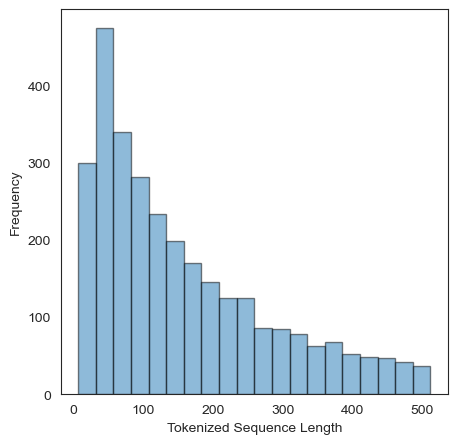

In [20]:
for q in [0.5, 0.75, 0.9]:
    print(f"{q} quantile: {np.quantile(seq_len, q)}")

sns.set_style("white")

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(seq_len, bins=20, color="tab:blue", alpha=0.5, edgecolor="k")
ax.set_xlabel("Tokenized Sequence Length")
ax.set_ylabel("Frequency")
plt.show()

In [21]:
# loader sizes
sample_sizes = {}
for split in ["train", "val", "test"]:
    loader = get_train_loader("standard", dataset.get_subset(split), batch_size=1)
    print(f"{split} loader size: {len(loader)}.")
    sample_sizes[split] = len(loader)

train loader size: 245502.
val loader size: 100050.
test loader size: 100050.


In [22]:
np.random.seed(123)

for split in ["train", "val", "test"]:
    idx = np.random.choice(sample_sizes[split], DATA_SIZE, replace=False)
    input_ids, attn_masks, labels, metadata = get_split(split, tokenizer, max_length=SEQ_LEN, idx=idx)
    
    print(input_ids.shape)
    torch.save(input_ids, os.path.join(SAVE_DIR, f"{MODEL_NAME}_{split}_input_ids.pt"))
    torch.save(attn_masks, os.path.join(SAVE_DIR, f"{MODEL_NAME}_{split}_attn_masks.pt"))
    torch.save(labels, os.path.join(SAVE_DIR, f"{MODEL_NAME}_{split}_labels.pt"))
    torch.save(metadata, os.path.join(SAVE_DIR, f"{MODEL_NAME}_{split}_metadata.pt"))

Loader size: 245502.


245502it [01:39, 2460.01it/s]


torch.Size([50000, 100])
Loader size: 100050.


100050it [01:18, 1269.38it/s]


torch.Size([50000, 100])
Loader size: 100050.


100050it [01:18, 1268.53it/s]


torch.Size([50000, 100])


## Set Up Data and Model

In [3]:
LEARNING_RATE = 2e-5
ADAMW_TOLERANCE = 1e-8
BATCH_SIZE = 32
EPOCHS = 2
SEED = 123
BALANCE = 0.3 # data scaling
OBJECTIVE = "superquantile"
DEVICE = 1

In [4]:
def load_data(split):
    input_ids  = torch.load(os.path.join(SAVE_DIR, f"{MODEL_NAME}_{split}_input_ids.pt"))
    attn_masks = torch.load(os.path.join(SAVE_DIR, f"{MODEL_NAME}_{split}_attn_masks.pt"))
    labels     = torch.load(os.path.join(SAVE_DIR, f"{MODEL_NAME}_{split}_labels.pt"))
    metadata   = torch.load(os.path.join(SAVE_DIR, f"{MODEL_NAME}_{split}_metadata.pt"))
    return input_ids, attn_masks, labels, metadata

class MaskedSequenceClassificationDataset(Dataset):
    def __init__(self, input_ids, attn_masks, labels, metadata):
        self.input_ids = input_ids
        self.attn_masks = attn_masks
        self.labels = labels
        self.metadata = metadata

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, i):
        return self.input_ids[i], self.attn_masks[i], self.labels[i], self.metadata[i]

In [5]:
input_ids, attn_masks, labels, metadata = load_data("train")
train_dataset = MaskedSequenceClassificationDataset(input_ids, attn_masks, labels, metadata)

print(f"Original label distribution:  {np.bincount(train_dataset.labels.numpy()) / len(train_dataset)}")

label_dist = np.bincount(train_dataset.labels.numpy()) / len(train_dataset)
n_labels = len(label_dist)
rebalanced_dist = BALANCE * np.ones(shape=(n_labels,)) / n_labels + (1 - BALANCE) * label_dist
print(f"Rebalanced label distribution: {rebalanced_dist}")
# radon-nykodym derivative to go from unbalanced to balanced wieghts
rnd = rebalanced_dist / label_dist
sample_weight = rnd[train_dataset.labels.numpy()]

# use a weighted sampler for upsampling
# we can use more data in the forward pass with the same memory budget
n_samples = len(sample_weight) if OBJECTIVE == "erm" else 2 * len(sample_weight)
batch_size = BATCH_SIZE if OBJECTIVE == "erm" else 2 * BATCH_SIZE
train_dataloader = DataLoader(
    train_dataset, sampler=WeightedRandomSampler(sample_weight, n_samples, replacement=True), batch_size=batch_size, drop_last=True
)
# train_dataloader = DataLoader(
#     train_dataset, sampler=RandomSampler(train_dataset), batch_size=BATCH_SIZE
# )
print("{:>5,} training samples.".format(len(train_dataset)))


Original label distribution:  [0.0124 0.0261 0.0948 0.2929 0.5738]
Rebalanced label distribution: [0.06868 0.07827 0.12636 0.26503 0.46166]
10,000 training samples.


In [6]:
# test train_dataloader
labels = []
for step, batch in enumerate(train_dataloader):
    labels.append(batch[2].numpy())
labels = np.concatenate(labels)
print(f"Number of training labels:  {len(train_dataset.labels)}")
print(f"Number of observed labels:  {len(labels)}")
print(f"Resampled label distribution:  {np.bincount(labels) / len(labels)}")

Number of training labels:  10000
Number of observed labels:  19968
Resampled label distribution:  [0.06610577 0.07757412 0.123748   0.26958133 0.46299079]


In [7]:
input_ids, attn_masks, labels, metadata = load_data("val")
val_dataset = MaskedSequenceClassificationDataset(input_ids, attn_masks, labels, metadata)
print(np.bincount(val_dataset.labels.numpy()) / len(val_dataset))
validation_dataloader = DataLoader(
    val_dataset, sampler=SequentialSampler(val_dataset), batch_size=BATCH_SIZE
)
print("{:>5,} validation samples.".format(len(val_dataset)))

input_ids, attn_masks, labels, metadata = load_data("test")
test_dataset = MaskedSequenceClassificationDataset(input_ids, attn_masks, labels, metadata)
test_dataloader = DataLoader(
    test_dataset, sampler=RandomSampler(test_dataset), batch_size=BATCH_SIZE
)
print("{:>5,} test samples.".format(len(test_dataset)))

[0.0131 0.0277 0.0926 0.2827 0.5839]
10,000 validation samples.
10,000 test samples.


In [8]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=5,
    output_attentions=False,
    output_hidden_states=False,
    cache_dir=CACHE_DIR,
).to(DEVICE)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE, eps = ADAMW_TOLERANCE)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = EPOCHS * BATCH_SIZE * len(train_dataloader))

## Train

In [10]:
def to_dict_of_lists(lst):
    return {key: [i[key] for i in lst] for key in lst[0]}

def format_time(elapsed):
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [11]:
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    handlers=[
        logging.FileHandler(os.path.join(OUT_DIR, "output_{MODEL_NAME}_{OBJECTIVE}.log")),
        logging.FileHandler("output_{MODEL_NAME}_{OBJECTIVE}.log"),
        logging.StreamHandler(sys.stdout),
    ],
)

In [12]:
# Seed everything.
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

training_stats = []
total_t0 = time.time()
for epoch_i in range(EPOCHS):

    # ========================================
    #               Training
    # ========================================

    print("")
    logging.info("======== Epoch {:} / {:} ========".format(epoch_i + 1, EPOCHS))
    logging.info("Training...")

    t0 = time.time()
    total_train_loss = 0
    total_train_objective = 0
    total_train_accuracy = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            logging.info(
                "  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.   Loss: {:0.5f}".format(
                    step, len(train_dataloader), elapsed, total_train_loss / step
                )
            )

        b_input_ids = batch[0].to(DEVICE)
        b_input_mask = batch[1].to(DEVICE)
        b_labels = batch[2].to(DEVICE)

        model.zero_grad()

        if OBJECTIVE == "superquantile":
            # use only the examples with high loss.
            with torch.no_grad():
                output = model(
                    input_ids=b_input_ids,
                    attention_mask=b_input_mask,
                    labels=b_labels,
                    return_dict=True,
                )
                logits = output.logits
                losses = F.cross_entropy(logits, b_labels, reduction="none")
                sort, argsort = torch.sort(losses, stable=True)
                rank = torch.argsort(argsort)
        
                b_input_ids = b_input_ids[rank >= int(len(losses) / 2)]
                b_input_mask = b_input_mask[rank >= int(len(losses) / 2)]
                b_labels = b_labels[rank >= int(len(losses) / 2)]

        output = model(
            input_ids=b_input_ids,
            attention_mask=b_input_mask,
            labels=b_labels,
            return_dict=True,
        )

        loss = output.loss
        logits = output.logits

        # sample weighted loss
        # losses = F.cross_entropy(logits, b_labels, reduction="none")
        # # weights = compute_sample_weight(losses)
        # weights = rnd[b_labels] / rnd[b_labels].sum()
        # loss = weights @ losses

        total_train_loss += output.loss.item()
        total_train_objective += loss.item()
        loss.backward()
        

        # TODO: See if this is needed.
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        total_train_accuracy += flat_accuracy(logits.detach().cpu().numpy(), b_labels.detach().cpu().numpy())

    avg_train_loss = total_train_loss / len(train_dataloader)
    avg_train_objective = total_train_objective / len(train_dataloader)
    avg_train_accuracy = total_train_accuracy / len(train_dataloader)
    training_time = format_time(time.time() - t0)

    print("")
    logging.info("  Average training loss:      {0:.3f}".format(avg_train_objective))
    logging.info("  Average training objective: {0:.3f}".format(avg_train_objective))
    logging.info("  Average training accuracy:  {0:.3f}".format(avg_train_accuracy))
    logging.info("  Training epoch took:        {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================

    print("")
    logging.info("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0

    y_true = []
    y_pred = []
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(DEVICE)
        b_input_mask = batch[1].to(DEVICE)
        b_labels = batch[2].to(DEVICE)

        with torch.no_grad():
            output = model(
                input_ids=b_input_ids,
                attention_mask=b_input_mask,
                labels=b_labels,
            )
            loss = output.loss
            logits = output.logits

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to("cpu").numpy()

        y_pred.append(np.argmax(logits, axis=1))
        y_true.append(label_ids)

        # total_eval_accuracy += flat_accuracy(logits, label_ids)

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    avg_val_accuracy = accuracy_score(y_true, y_pred)
    logging.info("  Validation Accuracy: {0:.3f}".format(avg_val_accuracy))
    logging.info(classification_report(y_true, y_pred, zero_division=0.0))
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)
    logging.info("  Validation Loss: {0:.3f}".format(avg_val_loss))
    logging.info("  Validation took: {:}".format(validation_time))

    
    epoch_stats = {
        "epoch": epoch_i + 1,
        "train_loss": avg_train_loss,
        "train_acc": avg_train_accuracy,
        "val_loss": avg_val_loss,
        "val_acc": avg_val_accuracy,
        "train_time": training_time,
        "val_time": validation_time,
        "val_report": classification_report(y_true, y_pred, zero_division=0.0, output_dict=True)
    }
    with open(os.path.join(OUT_DIR, f"{MODEL_NAME}_{OBJECTIVE}_epoch_{epoch_i}.json"), "w") as f:
        json.dump(epoch_stats, f, indent=2)
    training_stats.append(epoch_stats)

print("")
logging.info("Training complete!")
logging.info(
    "Total training took {:} (h:mm:ss)".format(format_time(time.time() - total_t0))
)

# Save the model.
torch.save(model.state_dict(), os.path.join(OUT_DIR, f"{MODEL_NAME}_{OBJECTIVE}.pt"))
training_stats = to_dict_of_lists(training_stats)
with open(os.path.join(OUT_DIR, f"{MODEL_NAME}_{OBJECTIVE}_training_stats.json"), "w") as f:
    json.dump(training_stats, f, indent=2)


2024-06-01 16:23:59,478 [INFO] ======== Epoch 1 / 2 ========
2024-06-01 16:23:59,480 [INFO] Training...
2024-06-01 16:24:11,869 [INFO]   Batch    40  of    312.    Elapsed: 0:00:12.   Loss: 1.60212
2024-06-01 16:24:23,989 [INFO]   Batch    80  of    312.    Elapsed: 0:00:25.   Loss: 1.54519
2024-06-01 16:24:36,189 [INFO]   Batch   120  of    312.    Elapsed: 0:00:37.   Loss: 1.46404
2024-06-01 16:24:48,340 [INFO]   Batch   160  of    312.    Elapsed: 0:00:49.   Loss: 1.38631
2024-06-01 16:25:00,507 [INFO]   Batch   200  of    312.    Elapsed: 0:01:01.   Loss: 1.33111
2024-06-01 16:25:12,699 [INFO]   Batch   240  of    312.    Elapsed: 0:01:13.   Loss: 1.28048
2024-06-01 16:25:24,906 [INFO]   Batch   280  of    312.    Elapsed: 0:01:25.   Loss: 1.24271

2024-06-01 16:25:34,619 [INFO]   Average training loss:      1.215
2024-06-01 16:25:34,620 [INFO]   Average training objective: 1.215
2024-06-01 16:25:34,621 [INFO]   Average training accuracy:  0.367
2024-06-01 16:25:34,622 [INFO]   Tr